# Example 7: Source Spectrum

This example demonstrates how GeoDataFrames (gdfs) and V3_dataframe created by PT3S can be used with matplotlib to create an interactive depiction of a source spectrum.

# PT3S Release

In [1]:
#pip install PT3S -U --no-deps

# Necessary packages for this Example

In [2]:
# ...

# Imports

In [3]:
import os
import logging
import pandas as pd
from pandas import Timestamp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString, Point
from matplotlib.patches import Circle
import ipywidgets as widgets

#...

try:
    from PT3S import dxAndMxHelperFcts
except:
    import dxAndMxHelperFcts

try:
    from PT3S import Rm
except:
    import Rm

try:
    from PT3S import ncd
except:
    import ncd
#...

In [4]:
import importlib

In [5]:
#importlib.reload(ncd)

# Logging

In [6]:
logger = logging.getLogger()  

logFileName= r"Example7.log" 

loglevel = logging.DEBUG
logging.basicConfig(filename=logFileName
                        ,filemode='w'
                        ,level=loglevel
                        ,format="%(asctime)s ; %(name)-60s ; %(levelname)-7s ; %(message)s")    

fileHandler = logging.FileHandler(logFileName)     

logger.addHandler(fileHandler)

consoleHandler = logging.StreamHandler()
consoleHandler.setFormatter(logging.Formatter("%(levelname)-7s ; %(message)s"))
consoleHandler.setLevel(logging.INFO)
logger.addHandler(consoleHandler)

# Read Model and Results

In [7]:
dbFilename="Example5"
dbFile=os.path.join(os.path.dirname(os.path.abspath(dxAndMxHelperFcts.__file__))
                    +'/Examples/'
                    +dbFilename
                    +'.db3'
)

In [8]:
m=dxAndMxHelperFcts.readDxAndMx(dbFile=dbFile,preventPklDump=True,maxRecords=-1)#maxRecords=-1

INFO    ; Dx.__init__: dbFile (abspath): c:\users\aUserName\3s\pt3s\Examples\Example5.db3 exists readable ...
INFO    ; dxAndMxHelperFcts.readDxAndMx: 
+..\Examples\Example5.db3 is newer than
+..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MX1:
+SIR 3S' dbFile is newer than SIR 3S' mx1File
+in this case the results are maybe dated or (worse) incompatible to the model
INFO    ; dxAndMxHelperFcts.readDxAndMx: 
+..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.XML is newer than
+..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MX1:
+SirCalc's xmlFile is newer than SIR 3S' mx1File
+in this case the results are maybe dated or (worse) incompatible to the model
INFO    ; dxAndMxHelperFcts.readDxAndMx: running C:\\3S\SIR 3S\SirCalc-90-14-02-10_Potsdam\SirCalc.exe ...
INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...
INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


# Preparing Data

In [9]:
dfKNOT=m.V3_KNOT

In [10]:
dfROHR=m.gdf_ROHR

In [11]:
# Get soure signatures for start and end knot
dfROHR['srcvector_fkKI'] = dfROHR['fkKI'].map(dfKNOT.set_index('tk')['srcvector'])
dfROHR['srcvector_fkKK'] = dfROHR['fkKK'].map(dfKNOT.set_index('tk')['srcvector'])

In [12]:
QM=('STAT',
  'ROHR~*~*~*~QMAV',
  Timestamp('2024-01-09 23:00:00'),
  Timestamp('2024-01-09 23:00:00'))

In [13]:
dfROHR['srcvector_plot'] = np.where(dfROHR[QM] > 0, dfROHR['srcvector_fkKI'], dfROHR['srcvector_fkKK'])

In [14]:
dfROHR = dfROHR[dfROHR['KVR'] != 2.0]

# Plotting

In [15]:
colors = [np.array([255, 0, 0]), np.array([0, 0, 255])]

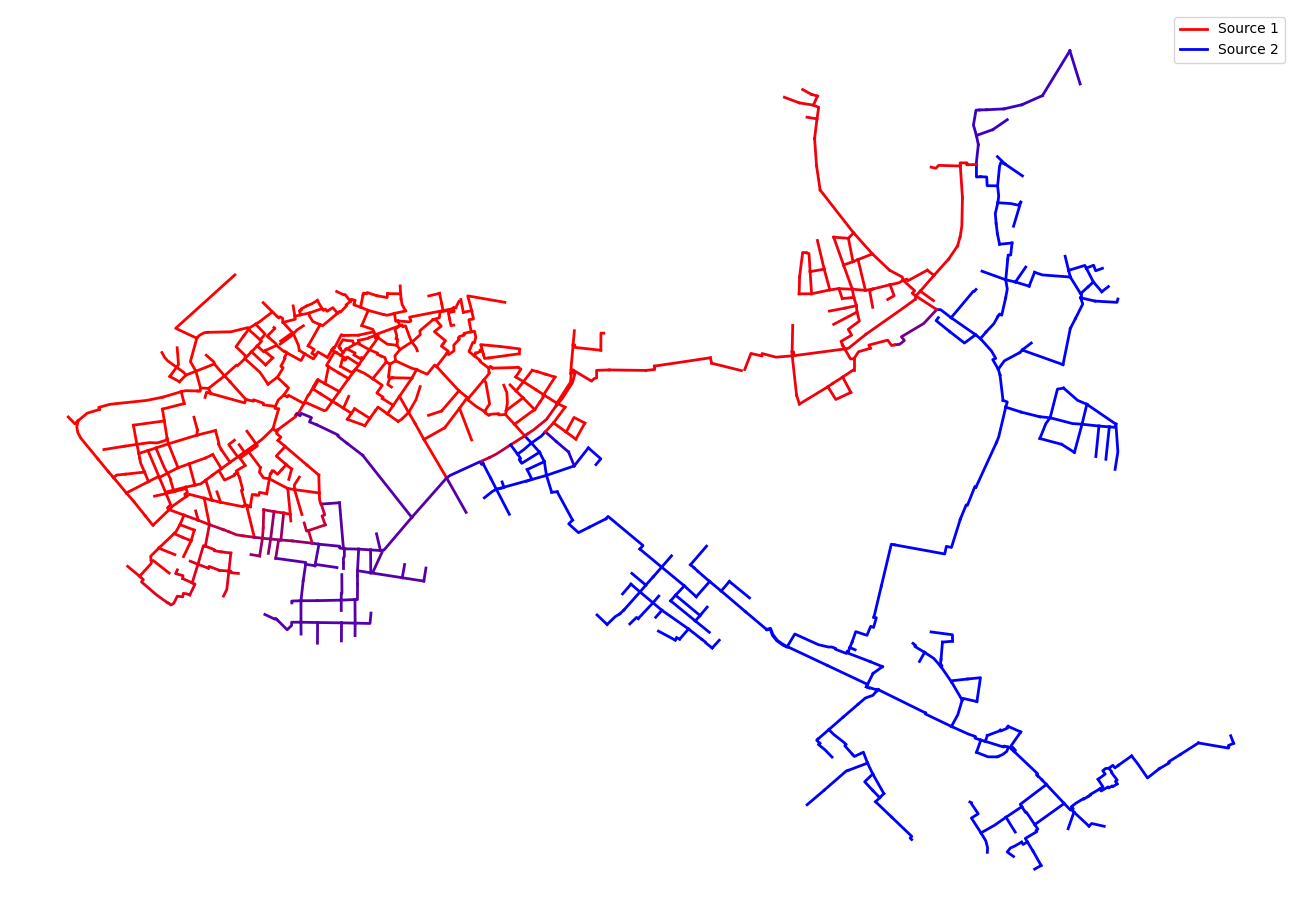

In [16]:
fig, ax = plt.subplots(figsize=Rm.DINA3q)
ncd.plot_src_spectrum(ax, dfROHR,'srcvector_plot', colors)
plt.show()

xlim = ax.get_xlim()
ylim = ax.get_ylim()
canvas_center = ((xlim[0] + xlim[1]) / 2, (ylim[0] + ylim[1]) / 2)

fig.savefig('Example7_Output_1.pdf')

# Plot with Pie Charts

## Prepara Data

In [17]:
dfROHR['srcvector_plot'] = dfROHR['srcvector_plot'].apply(lambda x: tuple(x) if isinstance(x, list) else x)

In [18]:
unique_values = dfROHR['srcvector_plot'].unique()

In [19]:
df = pd.DataFrame({
    'srcvector_plot': unique_values,
    'geometry': [dfROHR[dfROHR['srcvector_plot'] == value]['geometry'].iloc[0] for value in unique_values]
})

In [20]:
df[['left', 'right']] = pd.DataFrame(df['srcvector_plot'].tolist(), index=df.index)

df['left'] = df['left'].astype(int)
df['right'] = df['right'].astype(int)

In [21]:
df['pos'] = df['geometry'].apply(lambda geom: geom.interpolate(0.5) if isinstance(geom, LineString) else None)

In [23]:
def create_offset_point_away_from_midpoint(midpoint, canvas_center, scale=0.5):
    if midpoint is not None:
        # Calculate the direction vector from the canvas center to the midpoint
        direction_vector = Point(midpoint.x - canvas_center[0], midpoint.y - canvas_center[1])
        
        # Normalize the direction vector
        magnitude = (direction_vector.x**2 + direction_vector.y**2)**0.5
        normalized_vector = Point(direction_vector.x / magnitude, direction_vector.y / magnitude)
        
        # Create a point away from the midpoint in the direction away from the canvas center
        offset_point = Point(midpoint.x + normalized_vector.x * scale, midpoint.y + normalized_vector.y * scale)
        
        return offset_point
    return None

In [24]:
df['offset_point'] = df['pos'].apply(lambda pos: create_offset_point_away_from_midpoint(pos, canvas_center, scale=1000))

In [25]:
def create_circle_around_offset_point(offset_point, radius=1000):
    if offset_point is not None:
        return Point(offset_point.x, offset_point.y).buffer(radius)
    return None

In [26]:
df['circle'] = df['offset_point'].apply(lambda offset_point: create_circle_around_offset_point(offset_point, radius=1000))

In [53]:
#df.head()

In [28]:
df['helper_line'] = df.apply(lambda row: LineString([row['pos'], row['offset_point'].representative_point()]) if row['offset_point'] is not None else None, axis=1)

In [29]:
df = df.sort_values(by='left', ascending=True)

In [30]:
colors2=['red','blue']

## Plotting Functions

### Version 1 interactive

In [31]:
def plot_pie_charts_v1(ax, indexes, size=0.3, font_size=10, alpha=0.5):
    for index in indexes:
        if index < 0 or index >= len(df):
            print(f"Index {index} out of range")
            continue
    
        x = df['left'].iloc[index]
        y = df['right'].iloc[index]
        pos = df['pos'].iloc[index]

        x = int(x)
        y = int(y)
        
        # Only plot if both x and y are at least 15 or both are 0
        #if (x >= 15 and y >= 15) or (x == 0 and y == 0):
        if pos is not None:
            # Place the pie chart at the midpoint of the line
            inset_ax = ax.inset_axes([pos.x, pos.y, size, size], transform=ax.transData)
            pie_wedges, texts, autotexts = inset_ax.pie([x, y], labels=[' ', ' '], autopct='%1.1f%%', colors=colors2, textprops={'fontsize': font_size})
            
            # Set the alpha value for the pie chart wedges
            for wedge in pie_wedges:
                wedge.set_alpha(alpha)

### Version 1 output

In [32]:
def plot_pie_charts_v1_output(ax, indexes, size=0.3, font_size=10, alpha=0.5):
    for index in indexes:
        if index < 0 or index >= len(df):
            print(f"Index {index} out of range")
            continue
        
        x = df['left'].iloc[index]
        y = df['right'].iloc[index]
        pos = df['pos'].iloc[index]

        x = int(x)
        y = int(y)

        if pos is not None:
            # Place the pie chart at the midpoint of the line
            inset_ax = ax.inset_axes([pos.x, pos.y, size, size], transform=ax.transData)
            pie_wedges, texts, autotexts = inset_ax.pie([x, y], labels=[' ', ' '], autopct='%1.1f%%', colors=colors2, textprops={'fontsize': font_size})
            
            # Set the alpha value for the pie chart wedges
            for wedge in pie_wedges:
                wedge.set_alpha(alpha)
    
    fig.savefig('Example7_Output_2.pdf')

### Version 2 interactive

In [33]:
def plot_pie_charts_v2(ax, indexes, size=0.3, font_size=10, alpha=0.5):
    for index in indexes:
        if index < 0 or index >= len(df):
            print(f"Index {index} out of range")
            continue
        
        x = df['left'].iloc[index]
        y = df['right'].iloc[index]
        pos = df['pos'].iloc[index]

        x = int(x)
        y = int(y)
        circle = df['circle'].iloc[index]
        helper_line = df['helper_line'].iloc[index]
        
        if circle is not None:
            # Get the centroid of the circle to place the pie chart
            centroid = circle.centroid
            
            # Place the pie chart at the centroid of the circle
            inset_ax = ax.inset_axes([centroid.x, centroid.y, size, size], transform=ax.transData)
            pie_wedges, texts, autotexts = inset_ax.pie([x, y], labels=[' ', ' '], autopct='%1.1f%%', colors=colors2, textprops={'fontsize': font_size})
            
            # Set the alpha value for the pie chart wedges
            for wedge in pie_wedges:
                wedge.set_alpha(alpha)
            
            # Plot the helper line from the midpoint to the pie chart
            if helper_line is not None:
                ax.plot(*helper_line.xy, 'k--', transform=ax.transData)
    # Plot all offset points
    offset_points = df['offset_point'].dropna()
    ax.scatter([point.x for point in offset_points], [point.y for point in offset_points], color='red', label='Offset Points')

### Version 2 output

In [34]:
def plot_pie_charts_v2_output(ax, indexes, size=0.3, font_size=10, alpha=0.5):
    for index in indexes:
        if index < 0 or index >= len(df):
            print(f"Index {index} out of range")
            continue
        
        x = df['left'].iloc[index]
        y = df['right'].iloc[index]
        pos = df['pos'].iloc[index]

        x = int(x)
        y = int(y)
        circle = df['circle'].iloc[index]
        helper_line = df['helper_line'].iloc[index]
        
        if circle is not None:
            # Get the centroid of the circle to place the pie chart
            centroid = circle.centroid
            
            # Place the pie chart at the centroid of the circle
            inset_ax = ax.inset_axes([centroid.x, centroid.y, size, size], transform=ax.transData)
            pie_wedges, texts, autotexts = inset_ax.pie([x, y], labels=[' ', ' '], autopct='%1.1f%%', colors=colors2, textprops={'fontsize': font_size})
            
            # Set the alpha value for the pie chart wedges
            for wedge in pie_wedges:
                wedge.set_alpha(alpha)
            
            # Plot the helper line from the midpoint to the pie chart
            if helper_line is not None:
                ax.plot(*helper_line.xy, 'k--', transform=ax.transData)

    fig.savefig('Example7_Output_3.pdf')

## Plotting

### Version 1 interactive

In [35]:
#count = len(df[((df['left'] >= 15) & (df['right'] >= 15)) | ((df['left'] == 0) & (df['right'] == 0))])

In [36]:
def interactive_plot(**kwargs):
    fig, ax = plt.subplots(figsize=Rm.DINA3q) 
    ncd.plot_src_spectrum(ax, dfROHR, 'srcvector_plot', colors)
    
    for i in range(21): 
        if kwargs[f'Index_{i}']:
            plot_pie_charts_v1(ax, [i], size=750, alpha=0.5)
            
    plt.show()

In [37]:
checkboxes = {f'Index_{i}': widgets.Checkbox(value=False, description=f'{i}: {df["left"].iloc[i]}/{df["right"].iloc[i]}') for i in range(21)}

In [38]:
widgets_interact = widgets.interactive(interactive_plot, **checkboxes)

In [39]:
def update_plot(change):
    plt.clf()
    interactive_plot(**{key: checkboxes[key].value for key in checkboxes})

In [40]:
for key in checkboxes:
    checkboxes[key].observe(update_plot, names='value')

In [41]:
display(widgets_interact)

interactive(children=(Checkbox(value=False, description='0: 0/100'), Checkbox(value=False, description='1: 3/9…

### Version 1 output

In [54]:
indexes_to_plot =  [0, 5, 6, 9, 13, 20]

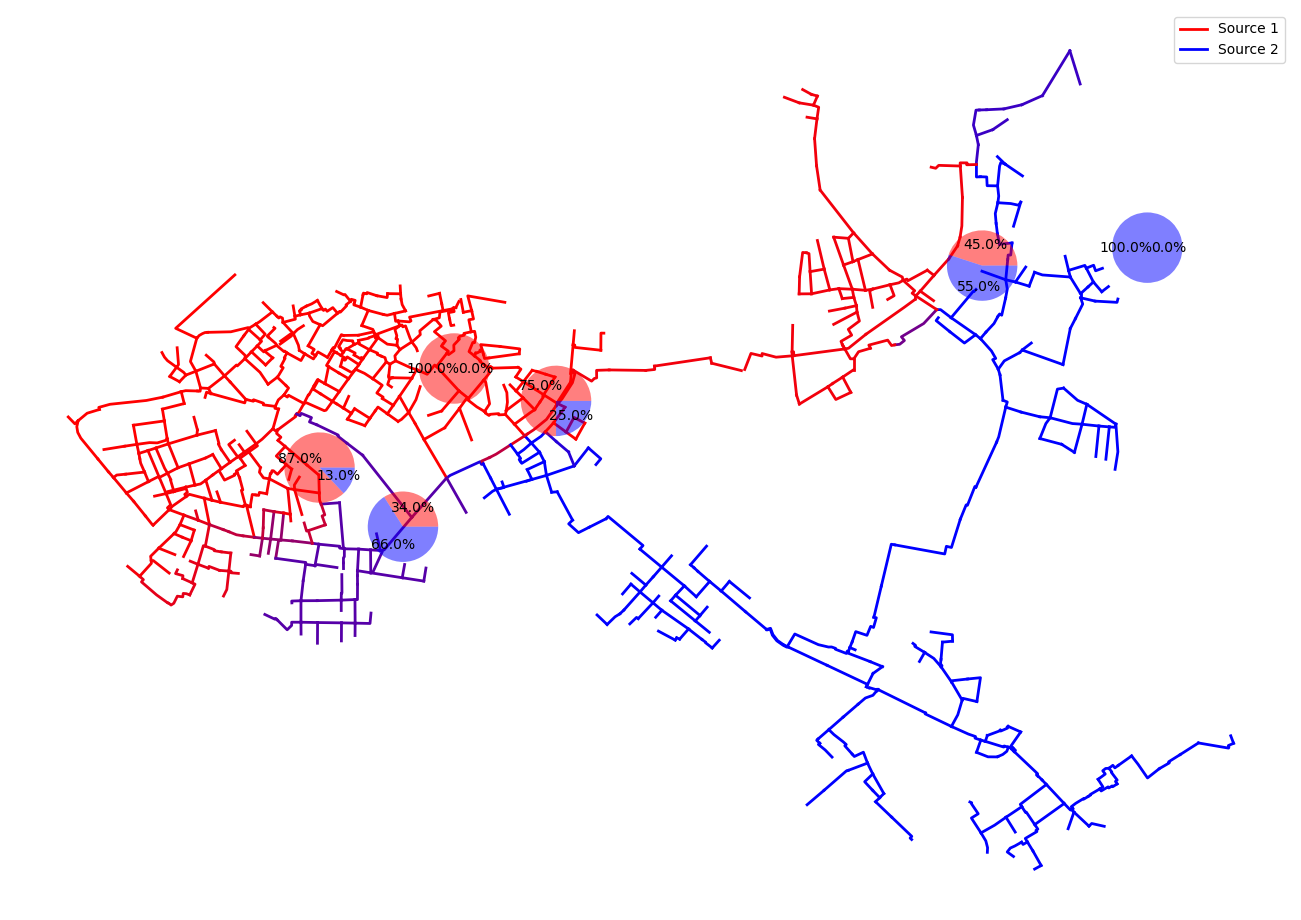

In [55]:
fig, ax = plt.subplots(figsize=Rm.DINA3q)
ncd.plot_src_spectrum(ax, dfROHR,'srcvector_plot', colors)
plot_pie_charts_v1_output(ax, indexes_to_plot, size=750, alpha=0.5)
plt.show()

### Version 2 interactive

In [45]:
def interactive_plot_2(**kwargs):
    fig, ax = plt.subplots(figsize=Rm.DINA3q)  
    ncd.plot_src_spectrum(ax, dfROHR, 'srcvector_plot', colors)
    
    for i in range(len(df)): 
        if kwargs.get(f'Index_{i}', False):
            plot_pie_charts_v2(ax, [i], size=750)
    
    plt.show()

In [46]:
# Create checkboxes with proportions and index as descriptions
checkboxes_2 = {f'Index_{i}': widgets.Checkbox(value=False, description=f'{i}: {df["left"].iloc[i]}/{df["right"].iloc[i]}') for i in range(21)}

In [47]:
widgets_interact_2 = widgets.interactive(interactive_plot_2, **checkboxes_2)

In [48]:
def update_plot_2(change):
    plt.clf()
    interactive_plot_2(**{key: checkboxes_2[key].value for key in checkboxes_2})

In [49]:
for key in checkboxes_2:
    checkboxes_2[key].observe(update_plot_2, names='value')

In [50]:
display(widgets_interact_2)

interactive(children=(Checkbox(value=False, description='0: 0/100'), Checkbox(value=False, description='1: 3/9…

### Version 2 output

In [56]:
indexes_to_plot = [0, 5, 6, 9, 13, 20]

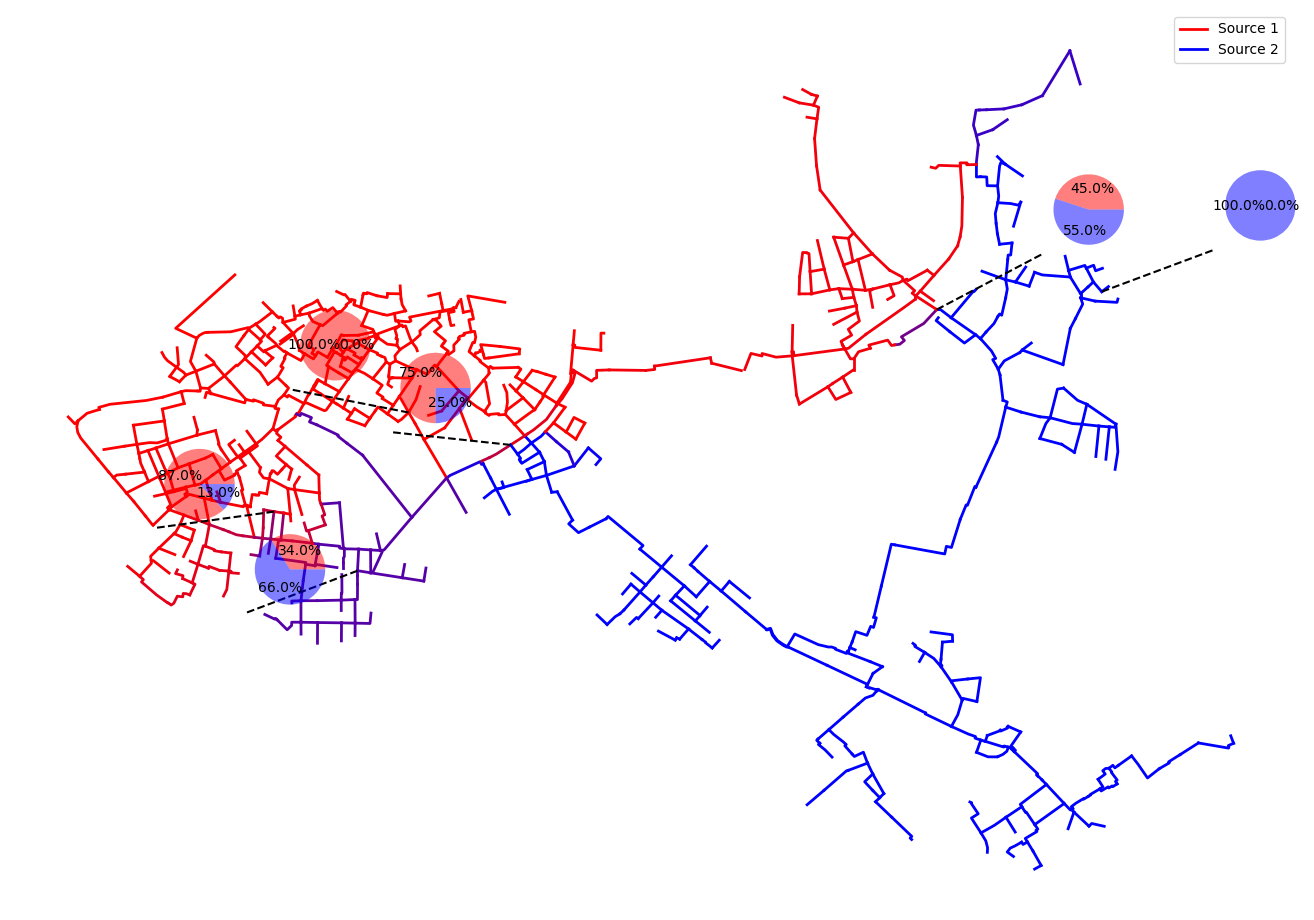

In [57]:
fig, ax = plt.subplots(figsize=Rm.DINA3q)
ncd.plot_src_spectrum(ax, dfROHR,'srcvector_plot', colors)
plot_pie_charts_v2_output(ax, indexes_to_plot, size=750, alpha=0.5)
plt.show()